# Modeling Phase 1: Naive Approach

**TL; DR**: this approach led to data leakage, but the cause of this leakage is very interesting and worth exploring  This is not the bulk of the project. Skip and go directly to Phase 2 if needed. 

In Phase 1, I will used the New York City dataset and the Income dataset to train the models. I will use **R2** to evaluate the models. I will engineer aggregated features based on each zipcode, and concat them back to the original data-frame. The benefit of this approach is two fold:
- we will be able to capture the general information of each zipcode.
- we will be able to retrain the same amount of data as the original dataset (n = 8166). This will ensure that we have sufficient amount data. 
The so-called “Naive Approach” is based on a simple idea: in theory we would be able to use all the original observations to train the models. 

The comments will be sparse throughout this phase. For the ease of your reading, go directly to the section [Investigate Data Leakage](#1) and [Conclusion](#2).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-Phase-1:-Naive-Approach" data-toc-modified-id="Modeling-Phase-1:-Naive-Approach-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling Phase 1: Naive Approach</a></span><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Merge-Goolge-dataset-with-Income-dataset" data-toc-modified-id="Merge-Goolge-dataset-with-Income-dataset-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Merge Goolge dataset with Income dataset</a></span></li><li><span><a href="#Shuffle-the-dataset" data-toc-modified-id="Shuffle-the-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Shuffle the dataset</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Create-interaction-columns-using-Google-dataset" data-toc-modified-id="Create-interaction-columns-using-Google-dataset-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Create interaction columns using Google dataset</a></span></li><li><span><a href="#Create-interaction-columns-using-demographic-information-from-'income'-dataset" data-toc-modified-id="Create-interaction-columns-using-demographic-information-from-'income'-dataset-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Create interaction columns using demographic information from 'income' dataset</a></span></li><li><span><a href="#Dummify-categorical-columns" data-toc-modified-id="Dummify-categorical-columns-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Dummify categorical columns</a></span></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Model-Preparation" data-toc-modified-id="Model-Preparation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Preparation</a></span></li><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Baseline Model</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Tree" data-toc-modified-id="Tree-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Tree</a></span></li><li><span><a href="#Investigate-Data-Leakage" data-toc-modified-id="Investigate-Data-Leakage-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Investigate Data Leakage</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Libraries to visualize Tree Based models
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

# Display Preference
pd.set_option('display.max_columns', None)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Read in data

In [2]:
google = pd.read_csv('../data/clean_google_data_nyc.csv')
income = pd.read_csv('../data/clean_income_by_zip_nyc.csv')

## Merge Goolge dataset with Income dataset

Note that 'inner' is used here for the merge. If any zipcode that doesn't exist in Google but in Income will be dropped and vice verse.

In [3]:
df = pd.merge(google, income, how='inner', left_on='zipcode', right_on='zipcode')

In [4]:
df.shape

(8166, 72)

In [5]:
df.head()

,zipcode,name,open_now,place_id,price_level,rating,user_ratings_total,searched_keyword,searched_zipcode,location_lat,location_lng,compound_code,global_code,art_gallery,atm,bakery,bar,beauty_salon,bicycle_store,book_store,cafe,car_dealer,car_repair,car_wash,clothing_store,convenience_store,department_store,drugstore,electronics_store,establishment,finance,florist,food,funeral_home,furniture_store,gas_station,general_contractor,grocery_or_supermarket,hair_care,hardware_store,health,home_goods_store,jewelry_store,laundry,liquor_store,local_government_office,locksmith,lodging,meal_delivery,meal_takeaway,movie_rental,night_club,park,parking,pet_store,pharmacy,point_of_interest,premise,restaurant,school,shoe_store,shopping_mall,spa,storage,store,supermarket,tourist_attraction,travel_agency,population,population_density_square_miles,housing_units,home_price_to_income_ratios
0,10031,Sugar Hill Cafe,True,ChIJTdM-m3z2wokR6xZB62deoYY,NaN,4.5,362,coffee shops,10030,40.824202,-73.945600,R3F3+MQ New York,87G8R3F3+MQ,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,60254,92805.8,23802,8.358221
1,10031,Pet Ark Inc,True,ChIJy4ahbGT2wokRyfIagpfOE0Y,NaN,4.4,93,stores,10031,40.823917,-73.951950,R2FX+H6 New York,87G8R2FX+H6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,60254,92805.8,23802,8.358221
2,10031,Grill on the Hill,True,ChIJheSk_GT2wokR-MLgSDMoiAk,2.0,4.1,385,restaurant,10031,40.822315,-73.950147,R2CX+WW New York,87G8R2CX+WW,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,60254,92805.8,23802,8.358221
3,10031,Foodtown of St. Nicholas Ave,True,ChIJAevUyn32wokRkzP0mEI6lIo,NaN,4.1,756,stores,10031,40.825960,-73.943139,R3G4+9P New York,87G8R3G4+9P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,60254,92805.8,23802,8.358221
4,10031,Hamilton's Cafe Restaurant,False,ChIJfeGy52L2wokRzh1E8y2l2MU,2.0,4.2,294,coffee shops,10031,40.827344,-73.949401,R3G2+W6 New York,87G8R3G2+W6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,60254,92805.8,23802,8.358221


## Shuffle the dataset
Shuffling the dataset is crucial; otherwise it would be problematic during the cross validation process, since Sklearn's cross validation does not shuffle the dataset.

In [6]:
index = df.index
df = shuffle(df)
df.index = index

## Feature Engineering

### Create interaction columns using Google dataset

In [7]:
df['price_level*rating'] = df['price_level'] * df['rating']

In [8]:
# Create column 'avg_price_level_by_zipcode', which calculate the avg price level for each zipcode
df['avg_price_level'] = [df.groupby('zipcode')['price_level'].mean()[zipcode] 
                                    for zipcode in df['zipcode']]

In [9]:
# Avarage rating by zipcode
df['avg_rating'] = [df.groupby('zipcode')['rating'].mean()[zipcode] 
                               for zipcode in df['zipcode']]

In [10]:
# Avarage rating_count by zipcode
df['avg_user_ratings_total'] = [df.groupby('zipcode')['user_ratings_total'].mean()[zipcode] 
                                           for zipcode in df['zipcode']]

In [11]:
# Total number of bars by zipcode. 
# Limitation: this approach has limiattion since our dataset is merely a sample of the businesses for each zipcode.
df['total_number_of_bars'] = [df.groupby('zipcode')['bar'].sum()[zipcode] 
                                         for zipcode in df['zipcode']]


In [12]:
# Total number of cafe by zipcode. 
# Limitation: this approach has limiattion since our dataset is merely a sample of the businesses for each zipcode.
df['total_number_of_cafes'] = [df.groupby('zipcode')['cafe'].sum()[zipcode] 
                                          for zipcode in df['zipcode']]

### Create interaction columns using demographic information from 'income' dataset

In [13]:
# Create column user ratings counts devided by the population in the given zipcode
df['user_ratings_total_per_capita'] = df['user_ratings_total'] / df['population']

In [14]:
# Create column rating weighed with population density in the given zipcode
df['rating_weighed_population_density'] = df['rating'] * df['population_density_square_miles']

### Dummify categorical columns

In [15]:
# drop_first=False since we might not use linear regression models
df = pd.get_dummies(df, columns=['open_now'], drop_first=False, dummy_na=True)

# Modeling

## Model Preparation

In [16]:
columns = [
       'price_level', 'rating',
       'user_ratings_total', 
       'art_gallery', 'atm', 'bakery', 'bar', 'beauty_salon', 'bicycle_store',
       'book_store', 'cafe', 'car_dealer', 'car_repair', 'car_wash',
       'clothing_store', 'convenience_store', 'department_store', 'drugstore',
       'electronics_store', 'establishment', 'finance', 'florist', 'food',
       'funeral_home', 'furniture_store', 'gas_station', 'general_contractor',
       'grocery_or_supermarket', 'hair_care', 'hardware_store', 'health',
       'home_goods_store', 'jewelry_store', 'laundry', 'liquor_store',
       'local_government_office', 'locksmith', 'lodging', 'meal_delivery',
       'meal_takeaway', 'movie_rental', 'night_club', 'park', 'parking',
       'pet_store', 'pharmacy', 'point_of_interest', 'premise', 'restaurant',
       'school', 'shoe_store', 'shopping_mall', 'spa', 'storage', 'store',
       'supermarket', 'tourist_attraction', 'travel_agency', 'population',
       'population_density_square_miles', 'housing_units',
       'home_price_to_income_ratios', 'price_level*rating',
       'avg_price_level', 'avg_rating',
       'avg_user_ratings_total', 'total_number_of_bars',
       'total_number_of_cafes', 'user_ratings_total_per_capita',
       'rating_weighed_population_density', 'open_now_False', 'open_now_True',
       'open_now_nan'
]

In [17]:
final = df[columns].dropna()

In [18]:
final.head()

,price_level,rating,user_ratings_total,art_gallery,atm,bakery,bar,beauty_salon,bicycle_store,book_store,cafe,car_dealer,car_repair,car_wash,clothing_store,convenience_store,department_store,drugstore,electronics_store,establishment,finance,florist,food,funeral_home,furniture_store,gas_station,general_contractor,grocery_or_supermarket,hair_care,hardware_store,health,home_goods_store,jewelry_store,laundry,liquor_store,local_government_office,locksmith,lodging,meal_delivery,meal_takeaway,movie_rental,night_club,park,parking,pet_store,pharmacy,point_of_interest,premise,restaurant,school,shoe_store,shopping_mall,spa,storage,store,supermarket,tourist_attraction,travel_agency,population,population_density_square_miles,housing_units,home_price_to_income_ratios,price_level*rating,avg_price_level,avg_rating,avg_user_ratings_total,total_number_of_bars,total_number_of_cafes,user_ratings_total_per_capita,rating_weighed_population_density,open_now_False,open_now_True,open_now_nan
0,2.0,4.3,672,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,68796,65283.5,23392,14.588243,8.6,1.461538,3.953333,255.555556,4,6,0.009768,280719.05,0,1,0
4,2.0,4.4,537,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,90761,6634.5,33268,5.594752,8.8,1.800000,4.105000,531.016667,5,17,0.005917,29191.80,0,1,0
5,2.0,4.3,585,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,37190,19084.4,13993,11.380786,8.6,1.600000,4.211321,191.075472,1,14,0.015730,82062.92,0,1,0
6,2.0,4.8,1153,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,42653,45228.0,20974,5.721885,9.6,1.675676,4.040816,470.163265,8,10,0.027032,217094.40,0,1,0
7,2.0,4.4,501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,44994,30556.6,16476,12.731369,8.8,1.476190,4.055556,136.466667,1,6,0.011135,134449.04,0,1,0


In [19]:
target = 'home_price_to_income_ratios'
X = final.drop(columns=target)
y = final[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.70)

## Baseline Model

[reference](https://chrisalbon.com/machine_learning/model_evaluation/create_baseline_regression_model/)

In [21]:
dummy_mean = DummyRegressor(strategy='mean', constant=20).fit(X_train, y_train)

In [22]:
print(f'train : {dummy_mean.score(X_train, y_train)}')
print(f'test : {dummy_mean.score(X_test, y_test)}')
print(f'cross_val : {cross_val_score(dummy_mean, X, y, cv=5).mean()}')

train : 0.0
test : -0.0012572008759987874
cross_val : -0.001022993273643591


## Linear Regression

In [23]:
lr = LinearRegression().fit(X_train, y_train)

In [24]:
print(f'train : {lr.score(X_train, y_train)}')
print(f'test : {lr.score(X_test, y_test)}')
print(f'cross_val : {cross_val_score(lr, X, y, cv=5).mean()}')

train : 0.21278943339142928
test : 0.2069494005789556
cross_val : 0.19281168031329965


## KNN

In [25]:
# Use a pipeline to combine StandardScaler and KNN
pipe = Pipeline(steps=[
    ('sc', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_params = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__p' : [1, 2],
    'knn__weights' : ['uniform', 'distance']
}

gs_knn = GridSearchCV(
    pipe,
    pipe_params,
    cv=5
).fit(X_train, y_train);

In [26]:
print(f'train : {gs_knn.score(X_train, y_train)}')
print(f'test : {gs_knn.score(X_test, y_test)}')
print(f'cross_val : {cross_val_score(gs_knn.best_estimator_, X, y, cv=5).mean()}')

train : 1.0
test : 0.641625202326495
cross_val : 0.6601743689164471


## Tree

In [27]:
# Use grid search to find best hyperparams
tree = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

In [28]:
print(f'train : {tree.score(X_train, y_train)}')
print(f'test : {tree.score(X_test, y_test)}')
print(f'cross_val : {cross_val_score(tree, X, y, cv=5).mean()}')

train : 1.0
test : 0.9993251792307041
cross_val : 0.9978545701738554


## Investigate Data Leakage
<a id='1'></a>

In [29]:
y_preds = tree.predict(X_test)

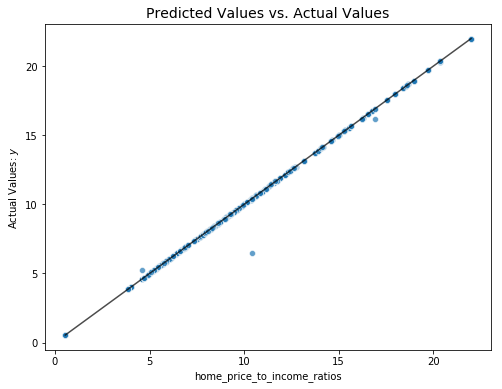

In [30]:
# 1st plot - y_true vs. y_pred
max_d = max(max(y_preds), max(y_test)) 
min_d = min(min(y_preds), min(y_test))

plt.figure(figsize=(8, 6))
plt.xlabel("Predicted Values: $\hat{y}$", fontsize=10)
plt.ylabel("Actual Values: $y$", fontsize=10)
plt.title('Predicted Values vs. Actual Values', fontsize=14)
ax = sns.scatterplot(x=y_test, y=y_preds, alpha=.7)
ax.plot((min_d, max_d),(min_d, max_d), c='black', alpha=.7);

For the tree Models, the simple `DecisionTreeRegressor` has a nearly perfect test score, and the cross validation score is close to the test score, which means that the test score is reliable. Comparing to the Linear Regression model, and KNN model, the simple plain Decision Tree Model outperformed by a mile. Based on the residual plots, we can see that we have a perfect fit since the points all fell on the diagonal line.

Have we magically found the model that can make perfect predictions? Let's look into the feature importance to see which features hold the most importance in making such perfect predicitons.

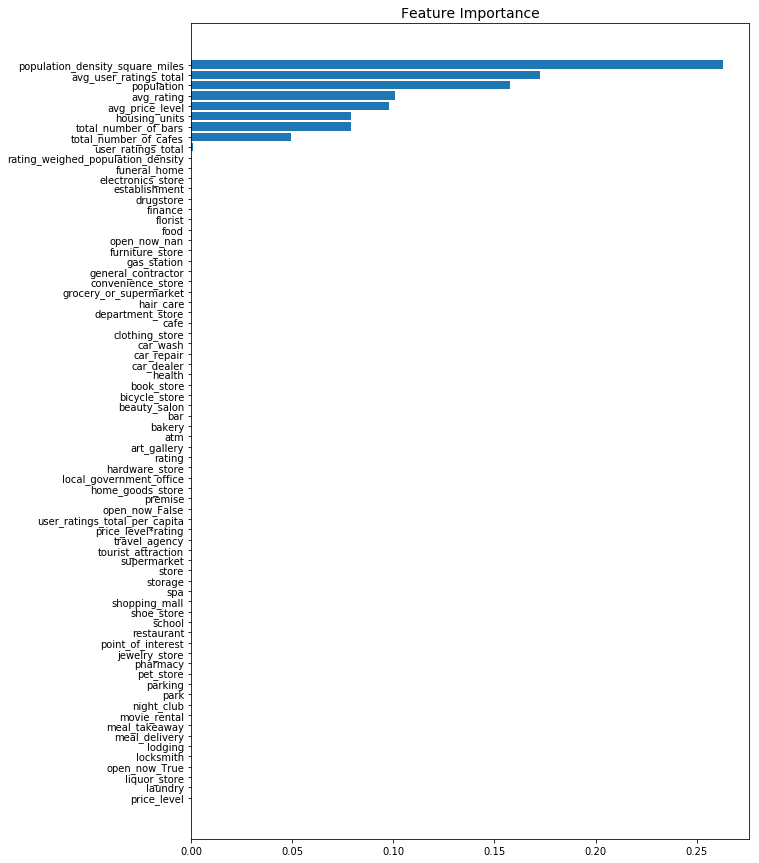

In [31]:
feature_importance = pd.DataFrame(dict(zip(X_train.columns, tree.feature_importances_)).items())
feature_importance = feature_importance.sort_values(by=[1])
plt.figure(figsize=(10, 15))
plt.title('Feature Importance', fontsize=14)
plt.barh(y = feature_importance[0], width=feature_importance[1]);

As we can see, the top features are either the census data or the aggregated features that were engineered. The rest of the features has no importance at all. This looks quite suspicious. Let's dig into the Decision Tree graph below and check how exactly the tree is making its decisions. 

In [32]:
cols = X.columns

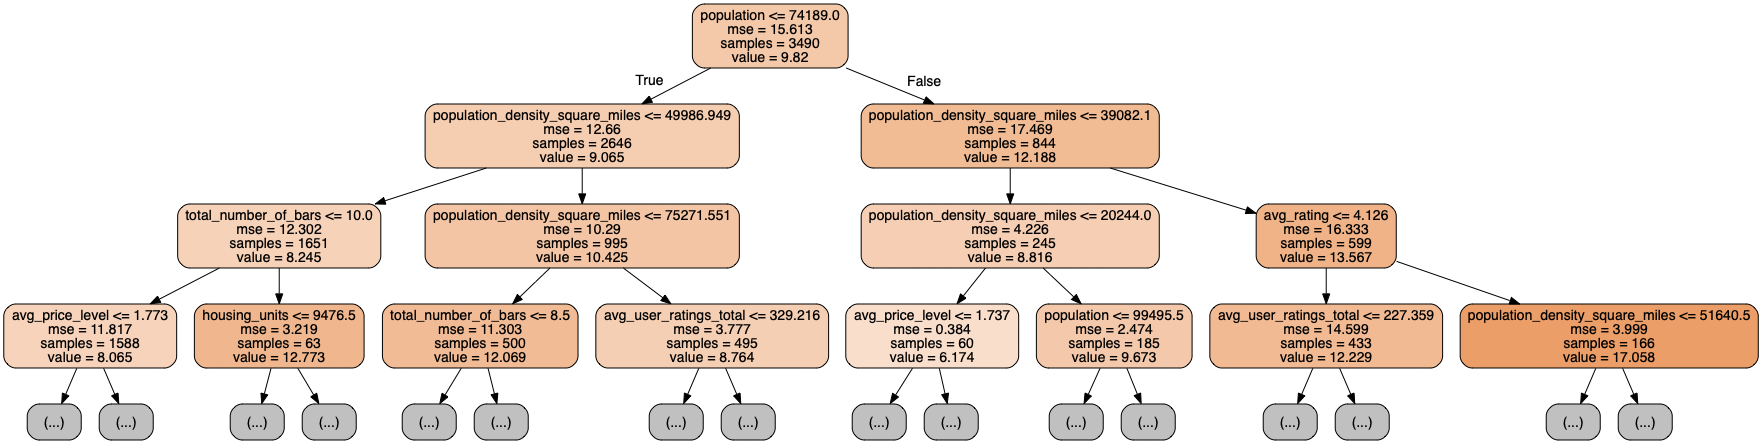

In [33]:
dot_data = StringIO()
export_graphviz(tree, 
                out_file=dot_data, 
                feature_names=cols, 
                filled=True, 
                rounded=True,
                max_depth=3
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

As we can see from the gragh, almost ALL the nodes are all cencus features and engineered features, while other features plays no parts in spliting the nodes. 

## Conclusion
<a id='2'></a>

From all the evidences above, we can infer that there is a data leakage issue. The following three steps combined caused the leakage: 
- The target was generated using zipcode.
- Zipcode was used to merge the Google Dataset and the Income dataset.
- Zipcode was used again to engineer aggregated values as features. 

To put it in a metaphorical way,  we can think the zipcode as a key, the features are a collection of locks, and the target is another lock. It happened that the key is able to open some locks in the features as well as the lock in the target. And the decision tree model is very good at picking out the right key. 

This leakage, however, is not apparent at first glance, since the feature 'zipcode' was not used in training the models. In addition, the other models such as Linear Regression and KNN did not share the same result. The result is that each model is fitted very differently, and the decision tree model was able to detect the zipcode pattern in our dataset. 

This conclude the Phase 1: the approach is invalid. However, this does NOT mean that in general we can't use aggregated features along with the original dataset; we just can't aggregated the observations the SAME way that we aggregated the target.